Yue write this code at 2023/08/02

The aim of the test is to figure out whether the unkown resistance will change with different position/current.

The result is that it is just dependent on the position but not other parameters.

# test on no-power situation


In [ ]:
## connection and calibration
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output
import numpy as np
import serial
import pickle

def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 


In [ ]:
# get the load_Cell initail value

ser = serial.Serial(  # 下面这些参数根据情况修改
  port='COM4',# 串口
  baudrate=57600,# 波特率
  parity=serial.PARITY_ODD,
  stopbits=serial.STOPBITS_TWO,
  bytesize=serial.SEVENBITS
)

# my_drive.axis1.controller.config.control_mode = 3
# my_drive.axis1.controller.input_pos=94/360
time.sleep(1)

#read the initial value of now
t0=time.monotonic()
delta=0
while delta<5:
  delta=time.monotonic()-t0
  data = ser.readline()
#   clear_output()
  try:
    print(int(data))
    cell_ini=int(data)
  except:
    print(data)

print('initial value of load cell',cell_ini)

In [ ]:
t0=time.monotonic()
delta=0

all_tor=[]
all_time=[]


desired_cur=0
sample_number=0
K=2.12e-5#unit: N
ARM=44#unit:mm

while True:
    sample_number+=1
    delta=time.monotonic()-t0
    all_time.append(time.monotonic()-t0)   
    #read the load cell
    load_cell = ser.readline() #will stuck here until receive data--so its frequency determine the whole test system frequency
    try:
        int(load_cell)
        torque=(int(load_cell)-cell_ini)*K*ARM #unit: N*mm
    except:
        torque=0
    all_tor.append(torque)
    #display the measurement
    if sample_number%5==0:
        clear_output()
        print('TORQUR: {:.2f}'.format(torque))


In [ ]:
print(len(all_time),len(all_tor))

In [ ]:
valid_time=[]
valid_tor=[]
for i in range(len(all_time)-1):
    if abs(all_tor[i])<10000:
        valid_time.append(all_time[i])
        valid_tor.append(all_tor[i])


fs=len(all_time)/30
print(fs)
y=lowpass_filter(valid_tor,3,fs,4)

label='input current='+str(0)
plt.plot(valid_time,valid_tor,label=label)
plt.plot(valid_time,y,'r',label='filtered data')
plt.legend(fontsize=18)
plt.xlabel('time(s)')
plt.ylabel('torque(N*mm)')
plt.show()

# test with power on


In [5]:
## connection and calibration
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output
import numpy as np
import serial
import pickle


def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')


def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 


In [8]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")
print(my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 4
print(my_drive.axis1.motor.current_control.i_gain)

# calibration and enter closed control mode
# print("starting calibration...")
# my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
# while my_drive.axis1.current_state != AXIS_STATE_IDLE:
#     time.sleep(0.1)
# check(my_drive)
# my_drive.axis1.motor.config.pre_calibrated = True
# my_drive.axis1.encoder.config.pre_calibrated =True
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis1.controller.input_torque = 0
check(my_drive)
print('*'*50)


finding an odrive...
Found! and the bus voltage is 30.477466583251953V
82.6633529663086
4.0
Everything is fine
**************************************************


In [9]:
# get the load_Cell initail value

ser = serial.Serial(  # 下面这些参数根据情况修改
  port='COM4',# 串口
  baudrate=57600,# 波特率
  parity=serial.PARITY_ODD,
  stopbits=serial.STOPBITS_TWO,
  bytesize=serial.SEVENBITS
)

# my_drive.axis1.controller.config.control_mode = 3
# my_drive.axis1.controller.input_pos=94/360
time.sleep(1)

#read the initial value of now
t0=time.monotonic()
delta=0
while delta<5:
  delta=time.monotonic()-t0
  data = ser.readline()
#   clear_output()
  try:
    print(int(data))
    cell_ini=int(data)
  except:
    print(data)

print('initial value of load cell',cell_ini)

b'HX711 not found.\r\n'
-151849
-151776
-151929
-151852
-152021
-151864
-151952
-151674
-151799
-151894
-151987
-151867
-151818
-151736
-151909
-151836
-151792
-151794
-151931
-151752
-151829
-151896
-151776
-151770
-151914
-151823
-151825
-151991
-151827
-152002
-151880
-151770
-151805
-151872
-151854
-151854
-151767
-151772
-151835
-151738
-151887
-151827
-151821
-151806
-151864
-151755
initial value of load cell -151755


## formal test with a fixed current input but rotating

In [54]:
# test the gravility impact on our load cell and modify it later
t0=time.monotonic()
delta=0
my_drive.axis1.controller.config.control_mode = 1
all_cur=[]
all_torque=[]
all_time=[]
all_input=[]
all_pos=[]

desired_cur=0
sample_number=0
K=2.12e-5#unit: N
ARM=44#unit:mm
VER_POS=18#position of motor when the load cell was vertical(degree)
GRAV=0.18#the max gravity impact of load cell(N)

while delta<30:
    sample_number+=1
    delta=time.monotonic()-t0
    my_drive.axis1.controller.input_torque=desired_cur
    current=my_drive.axis1.motor.current_control.Iq_measured
    now_position=my_drive.axis1.encoder.pos_circular
    now_position=now_position*360
    #read the load cell
    load_cell = ser.readline() #will stuck here until receive data--so its frequency determine the whole test system frequency
    try:
        int(load_cell)
        #modify the load cell gravity impact
        measure_f=(int(load_cell)-cell_ini)*K
        grav_angle=(VER_POS-now_position)*math.pi/180
        force=measure_f+math.sin(grav_angle)*GRAV
        torque=force*ARM
    except:
        torque=0

    
    all_time.append(delta)
    all_cur.append(current)
    all_input.append(desired_cur)
    all_pos.append(now_position)
    all_torque.append(torque)

    #display the measurement
    if sample_number%5==0:
        # desired_cur=delta*2
        clear_output()
        print('CURRENT: {:.2f}  \nPOSITION: {:.2f} \nTORQUE: {:.2f} \nINPUT: {:.2f}'.format(current,now_position,torque,desired_cur))
    
my_drive.axis1.controller.input_torque = 0
check(my_drive)
        

CURRENT: -0.39  
POSITION: 141.34 
TORQUE: -13.13 
INPUT: 0.00
Everything is fine


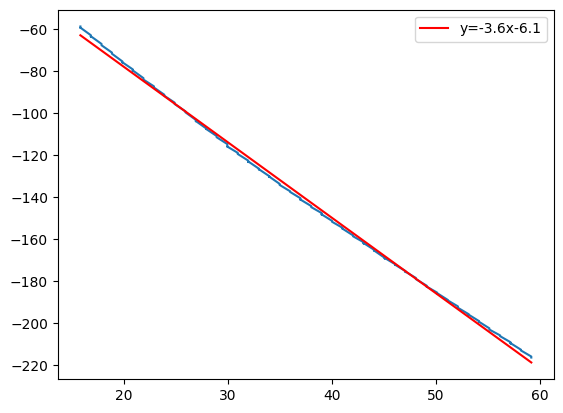

In [45]:
# print(len(all_torque),len(all_time))
valid_time=[]
valid_tor=[]
valid_input=[]
for i in range(len(all_time)):
    if  abs(all_torque[i])>0.1 and all_input[i]>15:
        valid_time.append(all_time[i])
        valid_tor.append(all_torque[i])
        valid_input.append(all_input[i])
plt.plot(valid_input,valid_tor)

x=np.array(valid_input)
y=np.array(valid_tor)
parameter = np.polyfit(x, y, 1)
expression='y={:.1f}x{:.1f}'.format(parameter[0],parameter[1])
y2=parameter[0]*x+parameter[1]
plt.plot(x,y2,'r',label=expression)

plt.legend()
plt.show()

33.56666666666667


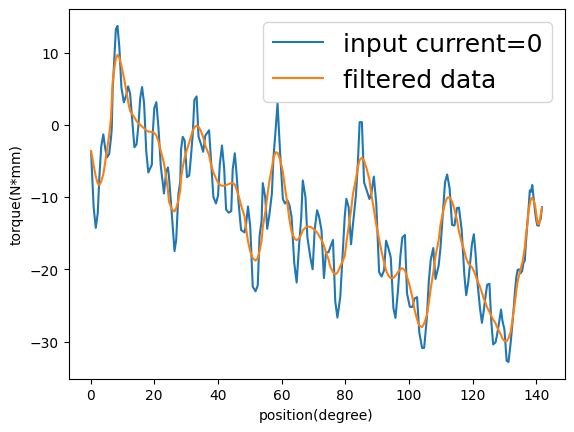

In [55]:
valid_time=[]
valid_tor=[]
valid_pos=[]
for i in range(len(all_time)):
    if  abs(all_torque[i])>0.1 and all_pos[i]<200:
        valid_time.append(all_time[i])
        valid_tor.append(all_torque[i])
        valid_pos.append(all_pos[i])

fs=len(all_time)/30
print(fs)
y=lowpass_filter(valid_tor,3,fs,4)

label='input current='+str(all_input[1])
plt.plot(valid_pos,valid_tor,label=label)
plt.plot(valid_pos,y,label='filtered data')
plt.legend(fontsize=18)
# plt.ylim(-220,0)
# plt.xlim(0,80)
plt.xlabel('position(degree)')
plt.ylabel('torque(N*mm)')
plt.show()

speed=(all_pos[-88]-all_pos[-66])/(all_time[-88]-all_time[-66])
test_data=[valid_time,valid_tor,valid_pos]
filepath='./test/fixed_input_at_{}A_with_{}speed.pkl'.format(int(all_input[-10]),int(speed))
pickle.dump(test_data,open(filepath,'wb'))

In [ ]:
plt.plot(valid_time,valid_pos)
plt.show()

In [ ]:
plt.plot(all_time,all_cur,label='measured current')
plt.plot(all_time,all_input,label='desired current')
plt.legend(fontsize=18)
plt.xlabel('time(s)')
plt.ylabel('current(A/10)')
plt.show()


valid_time=[]
valid_f=[]
for i in range(len(all_force)):
    if  abs(all_force[i])<1:
        valid_time.append(all_time[i])
        valid_f.append(all_force[i])


fs=len(all_time)/30
print(fs)
y=lowpass_filter(valid_f,3,fs,4)
plt.plot(valid_time,y)
plt.ylabel('force(N)')
plt.xlabel('time(s)')
plt.show()
print(max(valid_f),min(valid_f))

## verify#1: measure the static torque constant

In [ ]:
t00=time.monotonic()
t0=time.monotonic()


my_drive.axis1.controller.config.control_mode = 1

circle_num=0
add_num=0
sample_num=0

all_cur=[]
all_tor=[]
all_time=[]
all_input=[]

cell_flag=0

stable_tor=[]
stable_input=[]
stable_pos=[]

dif_cur_ini=[0]
desired_cur=dif_cur_ini[0]

cur_dif_ini=[]
tor_dif_ini=[]
time_dif_ini=[]
input_dif_ini=[]

K=2.12e-5#unit: N
ARM=44#unit:mm

while True:

    sample_num+=1
    delta=time.monotonic()-t0
    my_drive.axis1.controller.input_torque=desired_cur
    current=my_drive.axis1.motor.current_control.Iq_measured
    now_position=my_drive.axis1.encoder.pos_circular
    now_position=now_position*360
    
    all_time.append(time.monotonic()-t00)
    all_cur.append(current)
    all_input.append(desired_cur)
    
    #read the load cell
    load_cell = ser.readline() #will stuck here until receive data--so its frequency determine the whole test system frequency
    
    try:
        int(load_cell)
        
        torque=abs((int(load_cell)-cell_ini))*K*ARM #unit: N*mm
    except:
        torque=0
    all_tor.append(torque)

    #display the measurement
    if sample_num%5==0:
        clear_output()
        print('CURRENT: {:.2f}  \nPOSITION: {:.2f} \nTORQUR: {:.2f} \nINPUT: {:.2f}'.format(current,now_position,torque,desired_cur))

    #add current per one sec
    if delta>0.5:
        t0=time.monotonic()
        desired_cur+=0.1
        add_num+=1
        stable_tor.append(torque)
        stable_input.append(desired_cur)
        stable_pos.append(now_position)
       
    #finish the test circle of one initial torque value
    if desired_cur>18:
        my_drive.axis1.controller.input_torque = 0

        cur_dif_ini.append(all_cur)
        tor_dif_ini.append(all_tor)
        time_dif_ini.append(all_time)
        input_dif_ini.append(all_input)
        
        add_num=0
        circle_num+=1
        try:
            desired_cur=dif_cur_ini[circle_num]
        except:
            break

        clear_output()
        print('Finish the test circle with {} A/10 initial current'.format(dif_cur_ini[circle_num-1]))
        print('Begin the test circle with {} A/10 initial current'.format(dif_cur_ini[circle_num]))
        
        all_cur=[]
        all_angle=[]
        all_time=[]
        all_input=[]  

        time.sleep(2)
    
my_drive.axis1.controller.input_torque = 0
check(my_drive)
test_data=[stable_input,stable_tor,stable_pos]
filepath='./test/ramp_current_input_at_'+str(int(stable_pos[-1]))+'degree.pkl'
pickle.dump(test_data,open(filepath,'wb'))




In [ ]:

valid_input=[]
valid_tor=[]

# for i in range(400,len(all_input)):
#     if all_tor[i]>10 and all_tor[i]<100:
#         valid_input.append(all_input[i])
#         valid_tor.append(all_tor[i])


valid_input=stable_input[50:-1]
valid_tor=stable_tor[50:-1]


plt.scatter(valid_input,valid_tor,s=10,label='measured data point')

x=np.array(valid_input)
y=np.array(valid_tor)
parameter = np.polyfit(x, y, 1)
expression='y={:.1f}x+{:.1f}'.format(parameter[0],parameter[1])
y2=parameter[0]*x+parameter[1]
plt.plot(x,y2,'r',label=expression)
plt.title('motor angle={:.2f} degree'.format(stable_pos[-10]),fontsize=18)
# plt.plot(valid_input,valid_tor)
plt.legend(fontsize=18)
plt.xlabel('input(A/10)')
plt.ylabel('torque(N*mm)')
plt.show()